# Dataset

In [2]:
#Datos bd
import pandas as pd

df_msg = pd.read_csv('Message.csv')
df_cat = pd.read_csv('Category.csv')
df_user = pd.read_csv('User.csv') 

df_userMes = pd.read_csv('UserMessage.csv') 
df_mesCat = pd.read_csv('MessageCategory.csv') 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## EDA
In this section we are going to use only data_pp column.

In [3]:
df_msg= df_msg.dropna(subset=['data_pp'])

In [4]:
final = pd.merge(df_msg, df_mesCat, on='id_message')
final = pd.merge(final, df_cat, on='id_category')
final = pd.merge(final, df_userMes, on='id_message')

In [5]:
df = final.copy()

In [6]:
#df = df.drop(columns=['id_message', 'dataset','timestamp','data','id_forwarded','emojis','id_reply'])
df = df.drop(columns=['dataset','timestamp','data','id_forwarded','emojis','id_reply'])

## Training a Word2Vec model with the WSP dataset




In [8]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

2

In [9]:
sent = [row.split() for row in df.data_pp]

In [10]:
from gensim.models.phrases import Phrases, Phraser
phrases = Phrases(sent, min_count=10, progress_per=10000)

In [11]:
bigram = Phraser(phrases)

In [12]:
sentences = bigram[sent]

In [13]:
len(sentences.corpus)

552316

In [17]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

In [18]:
w2v_model.build_vocab(sentences, progress_per=1000)

In [19]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)


(16340551, 31293110)

In [20]:
w2v_model.wv.most_similar(positive=["kast"])

[('jose_antonio', 0.6732964515686035),
 ('kash', 0.6169741153717041),
 ('valores_cristianos', 0.6093415021896362),
 ('zurdo_minoria', 0.5997955799102783),
 ('jakast', 0.5897969007492065),
 ('muñeco', 0.5864868760108948),
 ('jak', 0.5828660726547241),
 ('votante_sichel', 0.5767176151275635),
 ('joseantoniokast', 0.5693546533584595),
 ('ja_kast', 0.5690985918045044)]

In [21]:
w2v_model.wv.most_similar(positive=["boric"])

[('boris', 0.6099845170974731),
 ('gabriel', 0.5697641372680664),
 ('x', 0.5313368439674377),
 ('gabriel_boric', 0.5059247016906738),
 ('guiño', 0.505487322807312),
 ('borich', 0.4947834610939026),
 ('kk', 0.4772879481315613),
 ('primaria', 0.4746960401535034),
 ('indeciso_apruebo', 0.46453768014907837),
 ('sepa', 0.46034377813339233)]

In [22]:
w2v_model.wv.most_similar(positive=["presidente"])

[('presidente_marxista', 0.6590309143066406),
 ('fuerza_energia', 0.6408284902572632),
 ('ir_votar', 0.6117882132530212),
 ('kash', 0.6114104986190796),
 ('amplio_mayoria', 0.6060326099395752),
 ('hormiga', 0.6050376892089844),
 ('union_fuerza', 0.5981168746948242),
 ('patriotas', 0.5965490341186523),
 ('jakast', 0.5961930155754089),
 ('triunfo', 0.5932756066322327)]

In [23]:
w2v_model.wv.similarity("kast", 'jose_antonio')

0.6732965

In [24]:
w2v_model.wv.doesnt_match(['kast', 'boric', 'politica','arbol'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'arbol'

### TSNE Visualization w2v

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [26]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


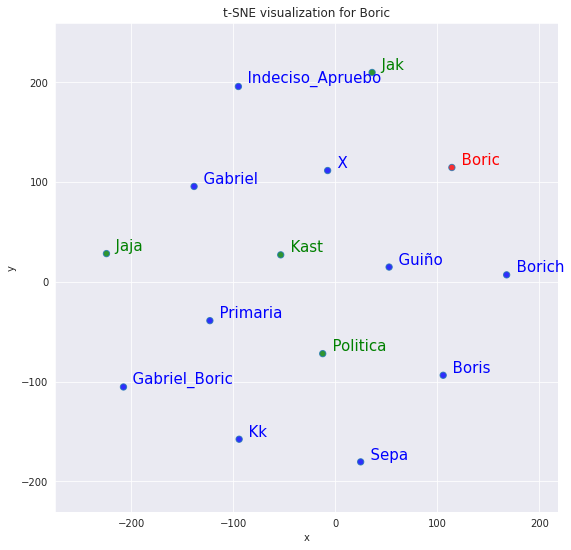

In [29]:
tsnescatterplot(w2v_model, 'boric', ['kast', 'politica', 'jaja', 'jak'])


In [30]:
#guarda y cargar con clase keyedv
w2v_model.wv.save_word2vec_format("w2v", binary=False)

In [32]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('/content/w2v')

Visualizarlo en la página http://projector.tensorflow.org/

In [ ]:

"""
0.1\t0.2\t0.5\t0.9
0.2\t0.1\t5.0\t0.2
0.4\t0.1\t7.0\t0.8
"""
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')

# Meta data file, `\n` seperated word
"""
token1
token2
token3
"""
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Write meta file and vector file
for index in range(len(w2v.index2word)):
    word = w2v.index2word[index]
    vec = w2v.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Then we can visuale using the `http://projector.tensorflow.org/` to visualize those two files.

# 1. Open the Embedding Projector.
# 2. Click on "Load data".
# 3. Upload the two files we created above: vecs.tsv and meta.tsv.


## Training a FastText model with the WSP dataset

In [33]:
from gensim.models import FastText

In [34]:
sent = [row.split() for row in df.data_pp]
phrases = Phrases(sent, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [35]:
model_ft = FastText(size=300, window=3, min_count=2)  
model_ft.build_vocab(sentences=sentences)
model_ft.train(sentences=sentences, total_examples=model_ft.corpus_count, epochs=10) 

In [36]:
model_ft.wv.most_similar(positive=["kast"])

[('\U0001f7e0kast', 0.9368119835853577),
 ('🏽kast', 0.9359661340713501),
 ('ja.kast', 0.9344140291213989),
 ('a.kast', 0.9282008409500122),
 ('🏾kast', 0.9265648126602173),
 ('kakast', 0.9248368740081787),
 ('kaste', 0.9243144989013672),
 ('kkast', 0.9239333868026733),
 ('jakast', 0.923224925994873),
 ('kkkast', 0.9225857853889465)]

In [37]:
model_ft.wv.most_similar(positive=["boric"])

[('borich', 0.9249445796012878),
 ('borič', 0.9218276739120483),
 ('borić', 0.9191256165504456),
 ('borih', 0.9172251224517822),
 ('boriiic', 0.9150739908218384),
 ('borichhh', 0.9119718670845032),
 ('borix', 0.9107323884963989),
 ('borii', 0.9096269607543945),
 ('boricc', 0.9056097269058228),
 ('bori', 0.9045765995979309)]

In [38]:
model_ft.wv.most_similar(positive=["weon"])

[('wueon', 0.9101506471633911),
 ('weonea', 0.8416351079940796),
 ('weonnn', 0.8364018201828003),
 ('neon', 0.8272923231124878),
 ('weone', 0.8233655691146851),
 ('wn', 0.8167201280593872),
 ('weonws', 0.8158466815948486),
 ('hueon', 0.8155079483985901),
 ('fachon', 0.8125617504119873),
 ('eon', 0.8079242706298828)]

In [39]:
similarities = model_ft.wv.most_similar(positive=['candidato', 'presidente'], negative=['boric'])
most_similar = similarities[0]

most_similar

('presidente_electo', 0.6646679639816284)

In [40]:
similarities = model_ft.wv.most_similar_cosmul(positive=['candidato', 'presidente'], negative=['boric'])
most_similar = similarities[0]
most_similar


('presidente_electo', 1.122850775718689)

In [41]:
not_matching = model_ft.wv.doesnt_match("candidato presidente boric jaja".split())
not_matching

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jaja'

In [42]:
sim_score = model_ft.wv.similarity('boric', 'kast')
sim_score

0.2921635

In [43]:
model_ft.corpus_total_words

3129311

In [70]:
#guarda y cargar con clase keyedv
model_ft.wv.save_word2vec_format("fast_text", binary=False)
ftt = KeyedVectors.load_word2vec_format('/content/fast_text')

## Using Keybert with the word embeddings trained models

In [46]:
!pip install keybert

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 217 kB 11.0 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 3.5 MB 51.1 MB/s 
     |████████████████████████████████| 1.2 MB 50.3 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
     |████████████████████████████████| 6.5 MB 44.0 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
  Created wheel for keybert: filename=keybert-0.5.0-py3-none-any.whl size=20491 sha256=32ec7d4b096293954e0de7a785dd56bc4577148ecf1efe36f9da88e6f9d78a79
  Stored in directory: /root/.cache/pip/wheels/99/1f/3f/590d2997adbb2d0e1f82e8ee05d42d6910e92c3ed283015ff8
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=77fe4aa16d6c5a153dbf07827602fbe6cfadad656c1daadb95f54d7cced1b91f
  Stored in directory: /root/.cache/pip/whee

### w2v + keybert

In [52]:
from keybert import KeyBERT
import gensim.downloader as api
from gensim.models.wrappers import FastText
import nltk
nltk.download('stopwords')

kw_model = KeyBERT(model=w2v)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:

doc = """
       En marzo de 2022, el actual presidente de Chile, Sebastián Piñera, deberá entregarle la banda presidencial a Gabriel Boric, uno de los líderes de la generación que puso en jaque su primer gobierno, 
       junto a decenas de dirigentes del movimiento estudiantil de 2011 que hoy son protagonista en todas las esferas de la política nacional. Un cambio acorde a los tiempos que enfrentamos y que, 
       después de meses turbulentos, parece retomar el cauce coherente de una sociedad que pidió cambios en las calles y se atrevió a coronarlos en las urnas.
        
      """

keywords = kw_model.extract_keywords(doc,highlight=True, stop_words=stopwords.words('spanish'))

En marzo de 2022, el actual presidente de Chile, Sebastián Piñera, deberá entregarle la banda
presidencial a Gabriel Boric, uno de los líderes de la generación que puso en jaque su primer
gobierno, junto a decenas de dirigentes del movimiento estudiantil de 2011 que hoy son 
protagonista en todas las esferas de la política nacional. Un cambio acorde a los tiempos que
enfrentamos y que, después de meses turbulentos, parece retomar el cauce coherente de una 
sociedad que pidió cambios en las calles y se atrevió a coronarlos en las urnas.

In [54]:
keywords

[('protagonista', 0.7936),
 ('coherente', 0.7637),
 ('acorde', 0.7564),
 ('estudiantil', 0.7252),
 ('sociedad', 0.7052)]

In [55]:

kw_model.extract_keywords(doc, keyphrase_ngram_range=(2, 2), stop_words=stopwords.words('spanish'))

[('protagonista todas', 0.7792),
 ('cambio acorde', 0.7748),
 ('cauce coherente', 0.7637),
 ('coherente sociedad', 0.7591),
 ('actual presidente', 0.748)]

In [56]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), 
                              use_mmr=True, diversity=0.7)

[('son protagonista en', 0.7936),
 ('atrevió coronarlos en', 0.0),
 ('cambios en las', 0.0),
 ('coronarlos en las', 0.0),
 ('deberá entregarle la', 0.0)]

In [57]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), 
                              use_mmr=True, diversity=0.2)

[('son protagonista en', 0.7936),
 ('nacional cambio acorde', 0.7846),
 ('el actual presidente', 0.748),
 ('protagonista en todas', 0.7792),
 ('primer gobierno junto', 0.7379)]

### fastext + keybert

In [58]:
from keybert import KeyBERT
import gensim.downloader as api
from gensim.models.wrappers import FastText
import nltk
nltk.download('stopwords')

kw_model = KeyBERT(model=ftt)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:

doc = """
       En marzo de 2022, el actual presidente de Chile, Sebastián Piñera, deberá entregarle la banda presidencial a Gabriel Boric, uno de los líderes de la generación que puso en jaque su primer gobierno, 
       junto a decenas de dirigentes del movimiento estudiantil de 2011 que hoy son protagonista en todas las esferas de la política nacional. Un cambio acorde a los tiempos que enfrentamos y que, 
       después de meses turbulentos, parece retomar el cauce coherente de una sociedad que pidió cambios en las calles y se atrevió a coronarlos en las urnas.
        
      """

keywords = kw_model.extract_keywords(doc,highlight=True, stop_words=stopwords.words('spanish'))

En marzo de 2022, el actual presidente de Chile, Sebastián Piñera, deberá entregarle la banda
presidencial a Gabriel Boric, uno de los líderes de la generación que puso en jaque su primer
gobierno, junto a decenas de dirigentes del movimiento estudiantil de 2011 que hoy son 
protagonista en todas las esferas de la política nacional. Un cambio acorde a los tiempos que
enfrentamos y que, después de meses turbulentos, parece retomar el cauce coherente de una 
sociedad que pidió cambios en las calles y se atrevió a coronarlos en las urnas.

In [60]:
keywords

[('cauce', 0.5615),
 ('presidencial', 0.536),
 ('acorde', 0.5259),
 ('coherente', 0.5061),
 ('movimiento', 0.5035)]

In [61]:

kw_model.extract_keywords(doc, keyphrase_ngram_range=(2, 2), stop_words=stopwords.words('spanish'))

[('banda presidencial', 0.6366),
 ('cauce coherente', 0.629),
 ('protagonista todas', 0.6243),
 ('actual presidente', 0.6116),
 ('movimiento estudiantil', 0.5734)]

In [62]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), 
                              use_mmr=True, diversity=0.7)

[('en las calles', 0.7515),
 ('gobierno junto decenas', 0.475),
 ('decenas dirigentes del', 0.0),
 ('esferas la política', 0.0),
 ('las esferas la', 0.0)]

In [63]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), 
                              use_mmr=True, diversity=0.2)

[('en las calles', 0.7515),
 ('protagonista en todas', 0.7414),
 ('la banda presidencial', 0.6366),
 ('sociedad que pidió', 0.6361),
 ('cauce coherente una', 0.629)]

### transformer + keybert

In [64]:
from keybert import KeyBERT
import gensim.downloader as api
from gensim.models.wrappers import FastText
import nltk
nltk.download('stopwords')

kw_model = KeyBERT()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [65]:

doc = """
       En marzo de 2022, el actual presidente de Chile, Sebastián Piñera, deberá entregarle la banda presidencial a Gabriel Boric, uno de los líderes de la generación que puso en jaque su primer gobierno, 
       junto a decenas de dirigentes del movimiento estudiantil de 2011 que hoy son protagonista en todas las esferas de la política nacional. Un cambio acorde a los tiempos que enfrentamos y que, 
       después de meses turbulentos, parece retomar el cauce coherente de una sociedad que pidió cambios en las calles y se atrevió a coronarlos en las urnas.
        
      """

keywords = kw_model.extract_keywords(doc,highlight=True, stop_words=stopwords.words('spanish'))

En marzo de 2022, el actual presidente de Chile, Sebastián Piñera, deberá entregarle la banda
presidencial a Gabriel Boric, uno de los líderes de la generación que puso en jaque su primer
gobierno, junto a decenas de dirigentes del movimiento estudiantil de 2011 que hoy son 
protagonista en todas las esferas de la política nacional. Un cambio acorde a los tiempos que
enfrentamos y que, después de meses turbulentos, parece retomar el cauce coherente de una 
sociedad que pidió cambios en las calles y se atrevió a coronarlos en las urnas.

In [66]:
keywords

[('chile', 0.5491),
 ('generación', 0.4909),
 ('movimiento', 0.425),
 ('coronarlos', 0.4145),
 ('presidencial', 0.3827)]

In [67]:

kw_model.extract_keywords(doc, keyphrase_ngram_range=(2, 2), stop_words=stopwords.words('spanish'))

[('presidente chile', 0.6589),
 ('generación puso', 0.5009),
 ('atrevió coronarlos', 0.4874),
 ('chile sebastián', 0.4859),
 ('política nacional', 0.4558)]

In [68]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), 
                              use_mmr=True, diversity=0.7)

[('actual presidente chile', 0.6425),
 ('turbulentos parece retomar', 0.3778),
 ('piñera deberá entregarle', 0.4266),
 ('2022 el actual', 0.3608),
 ('pidió cambios en', 0.2657)]

In [69]:
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), 
                              use_mmr=True, diversity=0.2)

[('actual presidente chile', 0.6425),
 ('coronarlos en las', 0.5688),
 ('presidente chile sebastián', 0.6268),
 ('la política nacional', 0.5293),
 ('la generación que', 0.5481)]